<a href="https://colab.research.google.com/github/hamzautd7/DDSMproject/blob/main/26_04_12am.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#installing the compatible version of pyTorch with fastai
!pip install torch===1.4.0 torchvision===0.5.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 43.9MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.4.0 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101


In [ ]:
%reload_ext autoreload
%autoreload 2

In [2]:
#importing fastai 
from fastai.imports import *
from fastai import data_block


In [3]:
#importing fastai vision
from fastai.vision import *
from fastai.metrics import error_rate, accuracy

import warnings
warnings.filterwarnings('ignore')
#mounting google drive to fetch the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd drive/MyDrive/Fire\ vs\ No\ Fire

/content/drive/MyDrive/Fire vs No Fire


In [5]:
#Extracting the training dataset from google drive into colab
import zipfile
with zipfile.ZipFile("Training.zip","r") as zip_ref:
    zip_ref.extractall("../../../sample_data/FirevsNoFire/")

In [6]:
#Extracting the test dataset from google drive into colab
import zipfile
with zipfile.ZipFile("Test.zip","r") as zip_ref:
    zip_ref.extractall("../../../sample_data/FirevsNoFire/")

In [7]:
# Setting path
path = Path('/content/sample_data/FirevsNoFire')
path.ls()

[PosixPath('/content/sample_data/FirevsNoFire/Training'),
 PosixPath('/content/sample_data/FirevsNoFire/Test')]

# **Creating a Databunch which can then be passed to a Learner**

Here, we will use the test set as a validation set since fastai considers the test set as unlabeled data so the we will do it in this way.

In [9]:
# Create a databunch 
# Using fastai transformations 
data = ImageDataBunch.from_folder(path, train='Training', valid='Test', ds_tfms=get_transforms(do_flip=False), size=254, bs=32, num_workers=8)

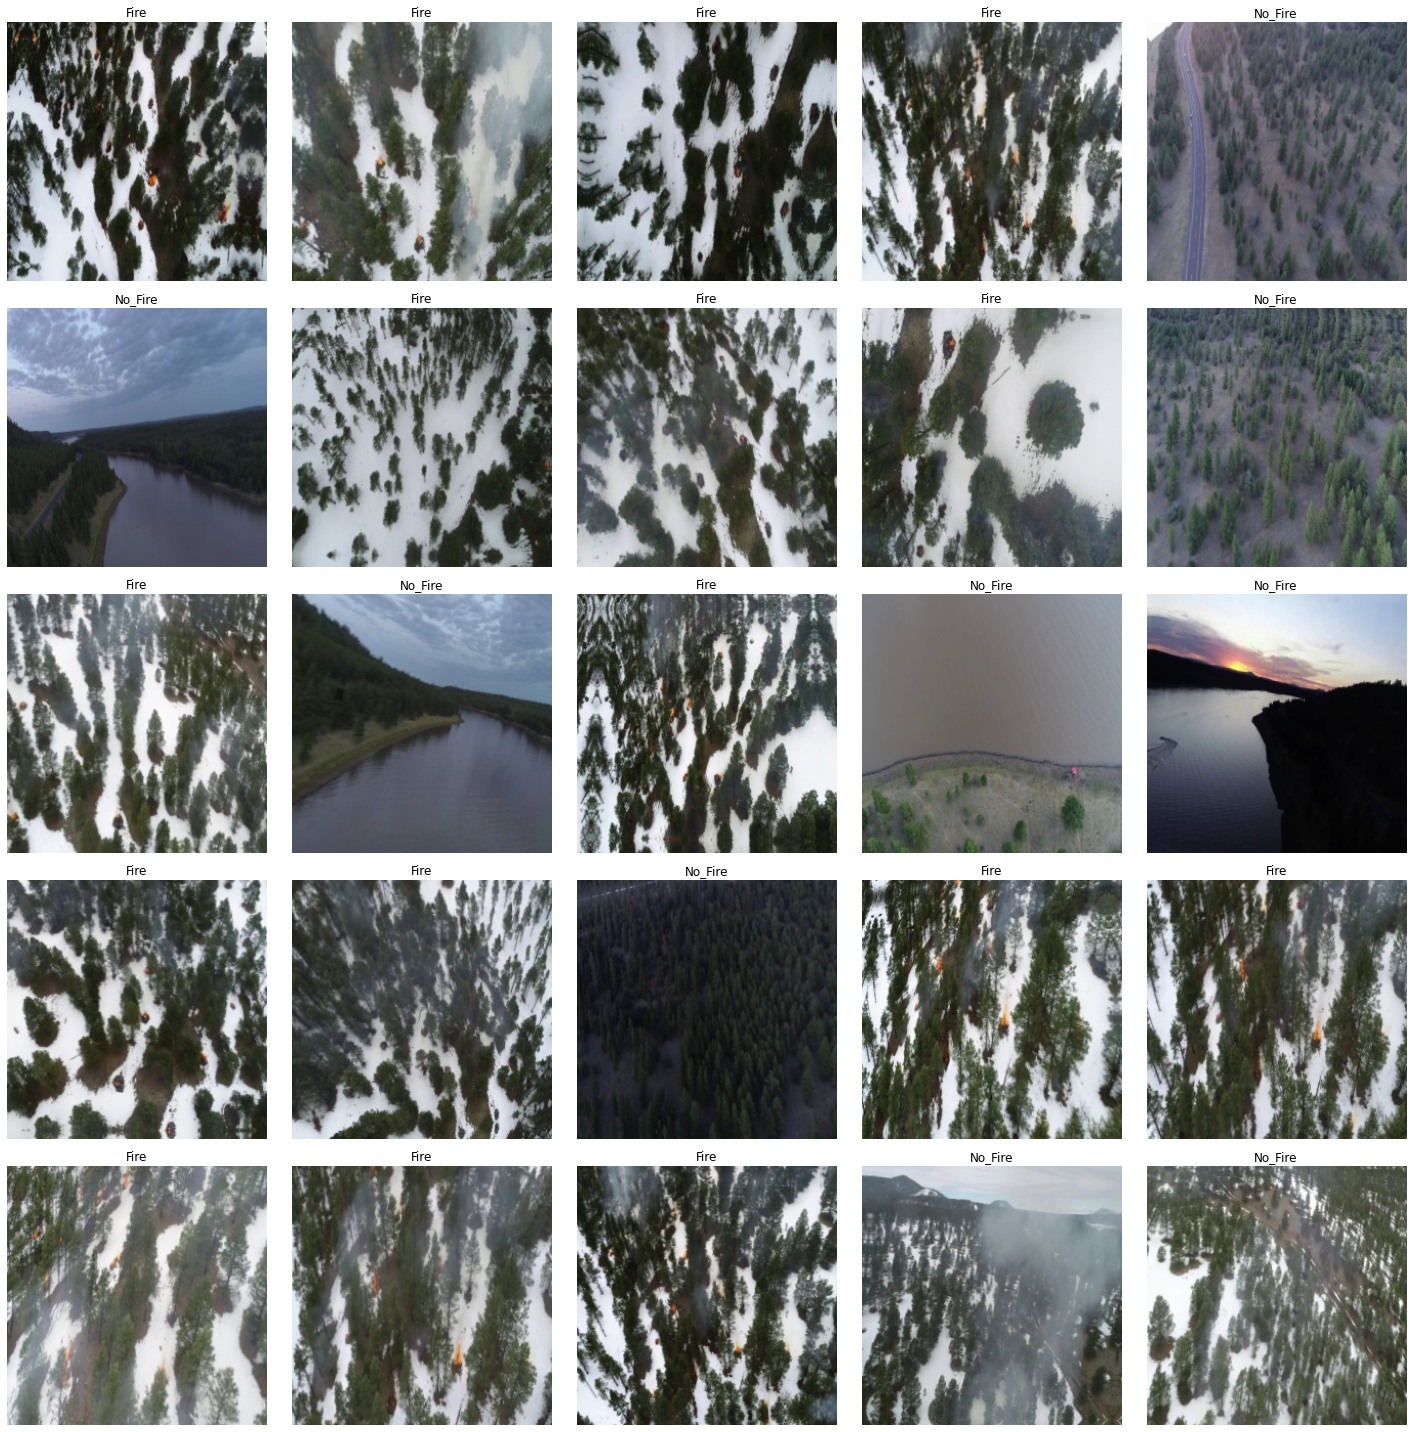

In [17]:
# Having a look at the data after transformations
data.show_batch()

In [18]:

# Check the number of images in the training and test set
print(data.classes,data.c)
print(len(data.train_ds), len(data.valid_ds))

['Fire', 'No_Fire'] 2
39375 8617


In [10]:
# ]CNN model with the pretrained resnet34
learn = cnn_learner(data, models.resnet34, metrics = [accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [ ]:
# Train the model for 4 epochs to try and reduce the training loss with default learning rate
learn.fit_one_cycle(4)

In [ ]:
%cd /content/sample_data/FirevsNoFire/models

[Errno 2] No such file or directory: '/content/sample_data/FirevsNoFire/models'
/content/drive/MyDrive/Fire vs No Fire


In [ ]:
# Save the model
learn.save('stage1-26_04_12am-resnet34')

# Load the Model
learn.load('stage1-26_04_12am-resnet34')

Learner(data=ImageDataBunch;

Train: LabelList (39375 items)
x: ImageList
Image (3, 254, 254),Image (3, 254, 254),Image (3, 254, 254),Image (3, 254, 254),Image (3, 254, 254)
y: CategoryList
Fire,Fire,Fire,Fire,Fire
Path: /content/sample_data/FirevsNoFire;

Valid: LabelList (8617 items)
x: ImageList
Image (3, 254, 254),Image (3, 254, 254),Image (3, 254, 254),Image (3, 254, 254),Image (3, 254, 254)
y: CategoryList
Fire,Fire,Fire,Fire,Fire
Path: /content/sample_data/FirevsNoFire;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, 

In [ ]:
# Build a Classification Interpretation object from our learn model
interp = ClassificationInterpretation.from_learner(learn)

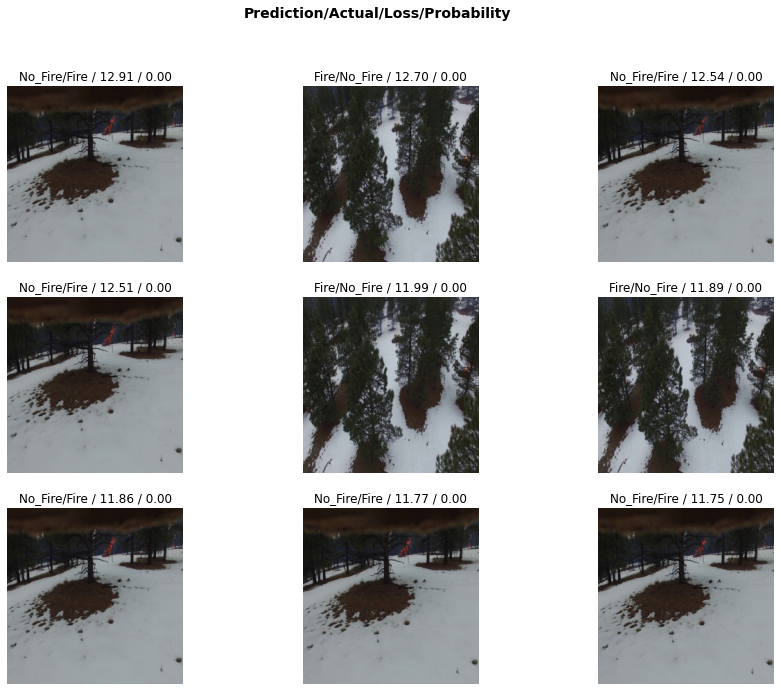

In [ ]:
# Show top 9 images with the highest loss
interp.plot_top_losses(9, figsize=(15,11))

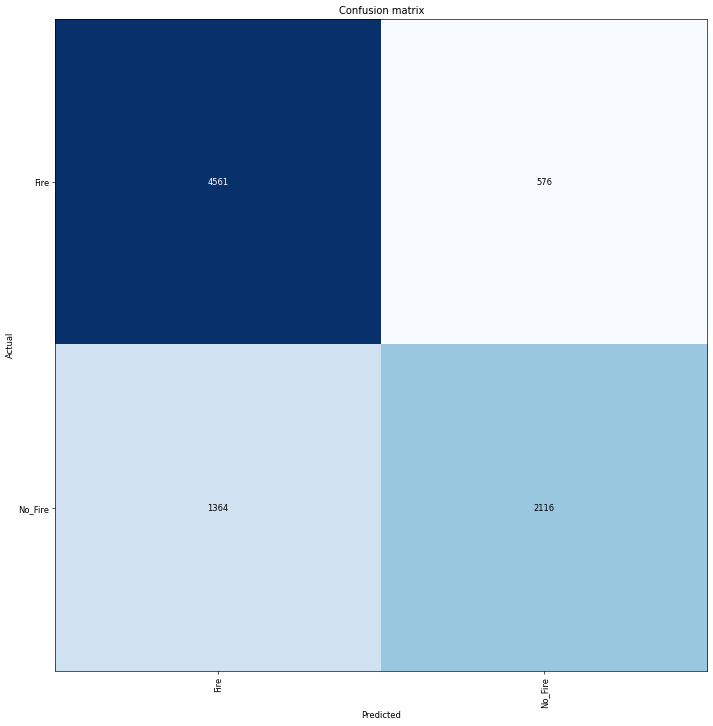

In [ ]:
# Build a confusion matrix
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
#Confusion
interp.most_confused(min_val=2)

[('No_Fire', 'Fire', 1364), ('Fire', 'No_Fire', 576)]

In [ ]:
# Unfreeze all layers of the CNN
learn.unfreeze()


In [ ]:

# Find the optimal learning rate 
learn.lr_find(stop_div=False, num_it=200)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.45E-01
Min loss divided by 10: 2.09E-07


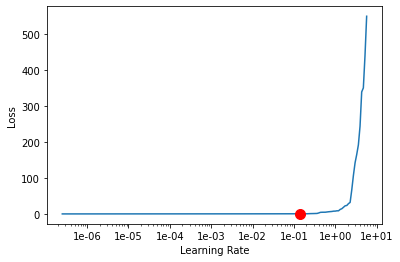

In [ ]:
learn.recorder.plot(suggestion=True)

In [ ]:
# Train again for 2 epochs 
# We will use discriminative learning rate
learn.fit_one_cycle(2, max_lr=slice(3e-5, 3e-3))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-07
Min loss divided by 10: 1.74E-08


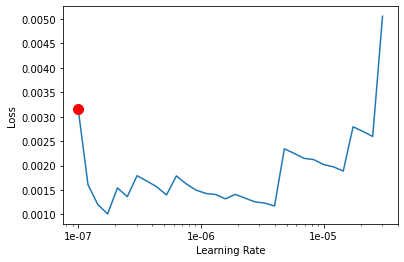

In [ ]:
learn.lr_find()
learn.recorder.plot(skip_start=0, skip_end=0,suggestion=True)

In [ ]:
# Fit the model for 4 more epochs to see if there's improvement
learn.fit_one_cycle(4, max_lr=slice(3e-5,3e-3))

In [ ]:
# Save the model
learn.save('stage2-26_04_12am-resnet34')

In [ ]:
learn.load('stage2-26_04_12am-resnet34')

Learner(data=ImageDataBunch;

Train: LabelList (39375 items)
x: ImageList
Image (3, 254, 254),Image (3, 254, 254),Image (3, 254, 254),Image (3, 254, 254),Image (3, 254, 254)
y: CategoryList
Fire,Fire,Fire,Fire,Fire
Path: /content/sample_data/FirevsNoFire;

Valid: LabelList (8617 items)
x: ImageList
Image (3, 254, 254),Image (3, 254, 254),Image (3, 254, 254),Image (3, 254, 254),Image (3, 254, 254)
y: CategoryList
Fire,Fire,Fire,Fire,Fire
Path: /content/sample_data/FirevsNoFire;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-07
Min loss divided by 10: 1.45E-08


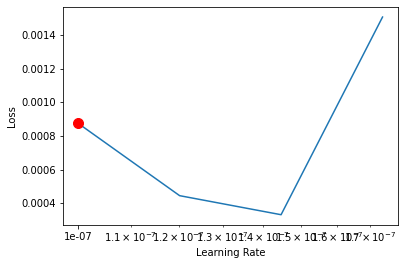

In [ ]:
learn.lr_find()
learn.recorder.plot(skip_start=0, skip_end=0,suggestion=True)

In [ ]:
# Fit the model for 3 epochs for 1 last time with an optimal learning rate
learn.fit_one_cycle(3, max_lr=slice(3e-5,3e-4))

In [ ]:
# Save the model
learn.save('stage3-26_04_12am-resnet34-90.2%')
learn.load('stage3-26_04_12am-resnet34-90.2%')

Learner(data=ImageDataBunch;

Train: LabelList (39375 items)
x: ImageList
Image (3, 254, 254),Image (3, 254, 254),Image (3, 254, 254),Image (3, 254, 254),Image (3, 254, 254)
y: CategoryList
Fire,Fire,Fire,Fire,Fire
Path: /content/sample_data/FirevsNoFire;

Valid: LabelList (8617 items)
x: ImageList
Image (3, 254, 254),Image (3, 254, 254),Image (3, 254, 254),Image (3, 254, 254),Image (3, 254, 254)
y: CategoryList
Fire,Fire,Fire,Fire,Fire
Path: /content/sample_data/FirevsNoFire;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, 

In [15]:
!pwd

/content/drive/MyDrive/Fire vs No Fire


In [18]:
%cp /content/drive/MyDrive/stage3-26_04_12am-resnet34-90.2%.pth /content/sample_data/FirevsNoFire/models/stage3-26_04_12am-resnet34-90.2%.pth

In [19]:
learn.load('stage3-26_04_12am-resnet34-90.2%')

Learner(data=ImageDataBunch;

Train: LabelList (39375 items)
x: ImageList
Image (3, 254, 254),Image (3, 254, 254),Image (3, 254, 254),Image (3, 254, 254),Image (3, 254, 254)
y: CategoryList
No_Fire,No_Fire,No_Fire,No_Fire,No_Fire
Path: /content/sample_data/FirevsNoFire;

Valid: LabelList (8617 items)
x: ImageList
Image (3, 254, 254),Image (3, 254, 254),Image (3, 254, 254),Image (3, 254, 254),Image (3, 254, 254)
y: CategoryList
No_Fire,No_Fire,No_Fire,No_Fire,No_Fire
Path: /content/sample_data/FirevsNoFire;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1

In [20]:
interp = ClassificationInterpretation.from_learner(learn)

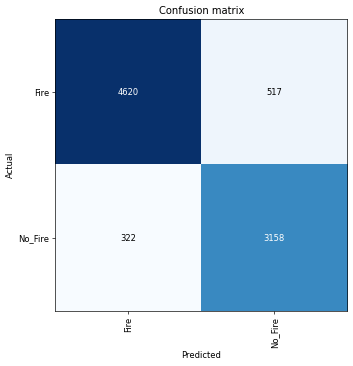

In [22]:
# Building a confusion matrix of the test set
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)